# Top Hat Filter

In this notebook we compare the ratio of $C_{\ell}^{\delta\delta}$ and $C_{\ell}^{\delta\kappa}$ using class and limber, and compare the results with the simple ratio expressions eq (25)


\begin{equation}
C_{\ell}^{\delta\kappa} = \frac{\ell(\ell +1)}{(\ell +1/2)^2}\frac{3 H_0^2\Omega_m(0)}{2}\int_{z_f^{\text{min}}}^{z_f^{\text{max}}}\text{d}z n_{\text{HI}}(z)\Sigma(z) (1+z)P_{\delta\delta}\Big[ \frac{\ell+1/2}{\chi(z)},z\Big]\int_{z_b^{\text{min}}}^{z_b^{\text{max}}} \text{d}z'n_{g}(z')\frac{\chi(z') - \chi(z)}{\chi(z)\chi(z')}
\end{equation}

\begin{equation}
C_{\ell}^{\delta\delta} = \int_{z_f^{\text{min}}}^{z_f^{\text{max}}} \text{d}z \frac{H(z)}{\chi^2(z)}n_g(z)P_{\delta\delta}\Big[\frac{\ell +1/2}{\chi(z)},z\Big]
\end{equation}


\begin{equation}
\text{ratio} = \frac{\ell(\ell+1)}{(\ell +1/2)^2}\frac{3 H_0^2\Omega_m(0)}{2 H(z_f)}(1+z_f) \frac{\Delta z_f}{\Delta z_b} \chi(z_f) \int_{z_b^{\text{min}}}^{z_b^{\text{max}}} \frac{\chi(z) - \chi(z_f)}{\chi(z)}\text{d}z
\end{equation}


For tophat filter we assume that $n_g(z) = 1/\Delta z$ $\implies \int n_g(z)dz = 1$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import simps
from scipy.interpolate import interp1d

In [2]:
# esthetic definitions for the plots
font = {'size'   : 16, 'family':'sans-serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='small'
plt.rcParams["figure.figsize"] = [8.0,6.0]

## Basic Parameters and Cosmology

In [3]:
window = 'tophat'

In [4]:
# Set basic parameters
kmax   = 10  #kmax to use
zmax   = 2.0
ellmax = 2000
nell   = 400

In [5]:
#Start by specifying the cosmology
cspeed = 299792.458 # km/s
omch2 = 0.12038
ombh2 = 0.022032
H0 = 67.556  # km/s/Mpc
h = 0.67556
A_s = 2.215e-9
n_s = 0.9619
tau_reion = 0.079
neff=3.046

In [6]:
# redshift bin 1
mu_z1    = 0.8
sigma_z1 = 0.11
delta_z1 = 0.22
# redshift bin 2
mu_z2    = 1.2
sigma_z2 = 0.1
delta_z2 = 0.2

In [7]:
ns = 4.0 # number of sigma in integration
nz = 401 # number of steps to use for the radial/redshift integration, odd because of Simpsons rule

In [8]:
def norm_gaussian(x,mu,sigma):
    return 1.0/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-0.5*(x-mu)**2/sigma**2)

# camb

In [9]:

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /opt/intel/oneapi/intelpython/python3.7/lib/python3.7/site-packages/camb


In [10]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()

#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0 = h*100, ombh2 = ombh2, omch2 = omch2,
                   tau=tau_reion, num_massive_neutrinos=0, mnu=0.0,standard_neutrino_neff=neff) #0.12038


#pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.InitPower.set_params(As = A_s, ns = n_s, pivot_scalar = 0.05) #2.215e-9


#Note non-linear corrections couples to smaller scales than you want
#pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)

#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up a range in chi, and calculate corresponding redshifts
results= camb.get_background(pars)

In [11]:
#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
#s8 = np.array(results.get_sigma8())

PK = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax, zmax=zmax,
    var1=model.Transfer_nonu,var2=model.Transfer_nonu)

# class

In [12]:
from classy import Class

# Define your cosmology (what is not specified will be set to CLASS default parameters)
params = {
    'output': 'nCl,sCl, mPk',
    'number count contributions': 'density',
    'selection' : window,
    'selection_mean' : str(mu_z1)+','+str(mu_z2),
    'selection_width' : str(delta_z1/2)+','+str(delta_z2/2),
    'l_max_lss' : '1200',
    'omega_b' : ombh2,
    'omega_cdm' : omch2,
    'h' : h,
    'A_s' : A_s,
    'n_s' : n_s,
    'tau_reio' : tau_reion,
    'N_eff': neff,
    'YHe' : 0.24,
    'N_ncdm' : 0,
    'l_switch_limber_for_nc_local_over_z' : '2',
    'l_switch_limber_for_nc_los_over_z' :'2',
    'non_diagonal' : '1',
    'z_max_pk':zmax
}

k_max = 1;

#Initialize the cosmology andcompute everything
cosmo = Class()
cosmo.set(params)



cosmo.compute()
#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1

#Call these for the nonlinear and linear matter power spectra
Plin = np.array([cosmo.pk_lin(ki, 0) for ki in k])

Plin_z0_intp = interp1d(k,np.array([cosmo.pk_lin(ki, 0) for ki in k]),kind='cubic')




background  = cosmo.get_background()
# comivng distance is in units Mpc
comoving_dist = background['comov. dist.']
ztab = background['z']

# interpolation function of comoving distance
comoving_dist_intp = interp1d(ztab,comoving_dist,kind='cubic')

Hubble = background['H [1/Mpc]']
Hubble_intp = interp1d(ztab,Hubble,kind='cubic')

growth_factor = background['gr.fac. D']
growth_factor_intp = interp1d(ztab,growth_factor,kind='cubic')

# $P_{\text{lin}}$  Comparison

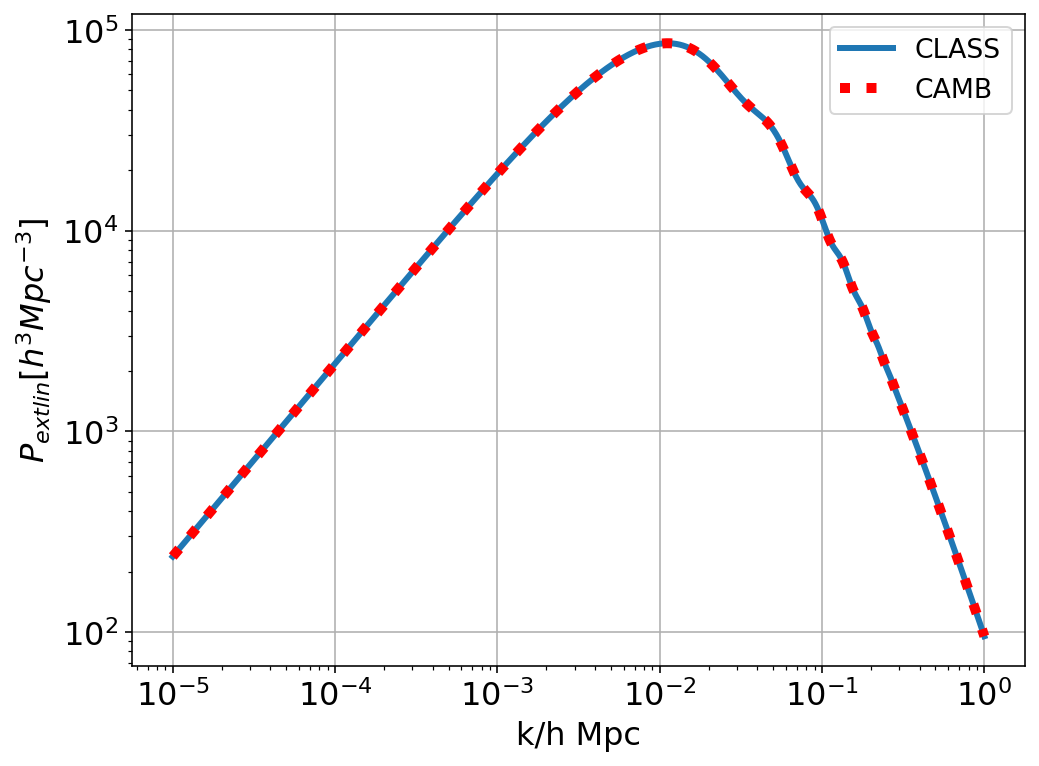

In [13]:
plt.xscale('log');
plt.yscale('log');
plt.plot(k, Plin_z0_intp(k), label='CLASS', linewidth=3)
#plt.plot(kh, pk[0,:], color='k', ls = line,label="CAMB",)
plt.plot(k,PK.P(0, k), color='r',label="CAMB",ls = 'dotted', linewidth=5)
plt.xlabel('k/h Mpc');
plt.ylabel('$P_{\text{lin}} [ h^3 Mpc^{-3}]$')
plt.grid()
plt.legend()


## compute class $C_{\ell}$

In [14]:
cls_dd_class=cosmo.density_cl(1000)

ll = cls_dd_class['ell']

cls_dd_class['dd']

cls_dd_class['dl']

{0: array([0.00000000e+00, 0.00000000e+00, 1.54234697e-09, ...,
        4.54488332e-16, 4.52604767e-16, 4.50730814e-16]),
 1: array([0.00000000e+00, 0.00000000e+00, 1.11713706e-08, ...,
        3.51395646e-15, 3.49942134e-15, 3.48496031e-15]),
 2: array([ 0.00000000e+00,  0.00000000e+00, -7.44690705e-10, ...,
        -1.30537740e-42, -1.20543088e-42, -1.10229137e-42])}

## Compute camb $C_{\ell}$

In [15]:
#Get angular power spectrum for galaxy number counts and lensing
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

In [16]:
pars.set_for_lmax(ellmax, lens_potential_accuracy=2)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False 
#NonLinear_both or NonLinear_lens will use non-linear corrections
#pars.NonLinear = model.NonLinear_both
pars.NonLinear = model.NonLinear_none
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = [
    GaussianSourceWindow(redshift=mu_z1, source_type='counts', bias=1.0, sigma=sigma_z1, dlog10Ndm=0.4),
    GaussianSourceWindow(redshift=mu_z2, source_type='lensing', sigma=sigma_z2)]

In [17]:
# set up camb ell array
l_camb  = np.arange(2, ellmax+1)
# compute C_l and extract from resulting dictionary
results = camb.get_results(pars)
cls     = results.get_source_cls_dict()
#
cltmp   = cls['W1xW2']
cl_dk   = cltmp[2:ellmax+1]/(l_camb*(l_camb+1.0))*(2.0*np.pi)
#
cltmp   = cls['W1xW1']
cl_dd   = cltmp[2:ellmax+1]/(l_camb*(l_camb+1.0))*(2.0*np.pi)

/opt/intel/oneapi/intelpython/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/opt/intel/oneapi/intelpython/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [18]:
#plt.plot(l_camb,cl_dd, label='camb', linewidth=3)
#plt.plot(ll[2:],cls_dd_class['dd'][0][2:], label='class')
#plt.xscale('log')
#plt.yscale('log')
#plt.legend()
#plt.ylabel(r'$C_{\ell}^{\delta\delta}$', fontsize=18)
#plt.xlabel(r'$\ell$')

In [19]:
#plt.plot(l_camb,cl_dk, label='camb', linewidth=3, color='r')
#plt.plot(ll[2:],(ll[2:]*(ll[2:]+1))*cls_dd_class['dl'][1][2:]/2, label='class', color='k')
#plt.xscale('log')
#plt.yscale('log')
#plt.legend()
#plt.ylabel(r'$C_{\ell}^{\delta\kappa}$', fontsize=18)
#plt.xlabel(r'$\ell$')

# Limber

## Compute Limber approximations

In [20]:
# set up redshift arrays in the two redshift bins
z1  = np.linspace(mu_z1-delta_z1/2,mu_z1+delta_z1/2,num=nz,endpoint=True)
z2  = np.linspace(mu_z2-delta_z2/2,mu_z2+delta_z2/2,num=nz,endpoint=True)
# set up ell-array for limber
l_limber = np.linspace(2,ellmax,nell)


In [21]:
# compute often used quantities once

#class
chi_z1    = comoving_dist_intp(z1) # returns comoving radial distance chi in Mpc
chi_z2    = comoving_dist_intp(z2) # returns comoving radial distance chi in Mpc
Hub_z1    =  Hubble_intp(z1)*cspeed

# Gaussian window functions
#W_z1      = norm_gaussian(z1,mu_z1,sigma_z1)
#W_z2      = norm_gaussian(z2,mu_z2,sigma_z2)

# tophat window functions
W_z1  = (1/delta_z1)
W_z2  = (1/delta_z2)

#
limber_ell_factor = (1.0+l_limber)*l_limber/(0.5+l_limber)**2 # we could simply set this to 1 w/o significant impact

Text(0, 0.5, '$H(z)$')

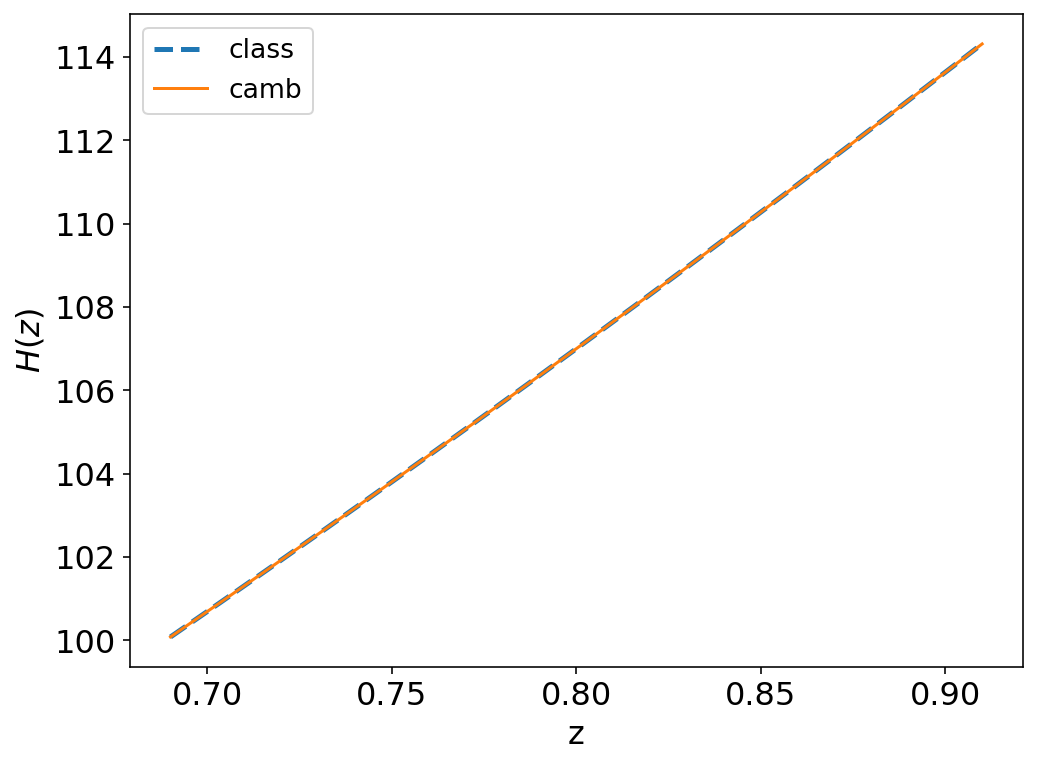

In [22]:
plt.plot(z1, Hubble_intp(z1)*cspeed, label = 'class', linestyle='dashed', linewidth=2.5)
plt.plot(z1,  results.hubble_parameter(z1),label = 'camb' )
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$H(z)$')

In [23]:
# Limber approximation for delta(z1)-kappa(z2) cross, our Eq. (20)
resarr_dk = np.zeros(np.size(l_limber))
#
for il, ell in enumerate(l_limber):
    Pkz = np.zeros(np.size(z1))
    res = np.zeros(np.size(z1))
    for nz, iz in enumerate(z1):
        kz      = (0.5+ell)/chi_z1[nz]
        Pkz[nz] = PK.P(iz, kz, grid=False)
        #Pkz[nz] = cosmo.pk_lin(kz, 0)*(growth_factor_intp(iz)**2)
        res[nz] = W_z1*(1.0+z1[nz])*Pkz[nz]*simps(W_z2*(chi_z2-chi_z1[nz])/(chi_z2*chi_z1[nz]),x=z2)
    resarr_dk[il] = simps(res,x=z1)
resarr_dk = resarr_dk*limber_ell_factor*1.5*(omch2+ombh2)*100.0**2/cspeed**2

In [24]:
# Limber approximation for delta(z1)-delta(z1), our Eq. (21)
resarr_dd = np.zeros(np.size(l_limber))
#
for il, ell in enumerate(l_limber):
    Pkz    = np.zeros(np.size(z1))
    for nz, iz in enumerate(z1):
        kz      = (0.5+ell)/chi_z1[nz]
        Pkz[nz] = PK.P(iz, kz, grid=False)
        #Pkz[nz] = cosmo.pk_lin(kz, 0)*(growth_factor_intp(iz)**2)
    resarr_dd[il] = simps(Hub_z1/cspeed/chi_z1**2*W_z1**2*Pkz,x=z1)

## plots : theory,  class

### $C_{\ell}^{\delta\delta}$

Text(0.5, 0, '$\\ell$')

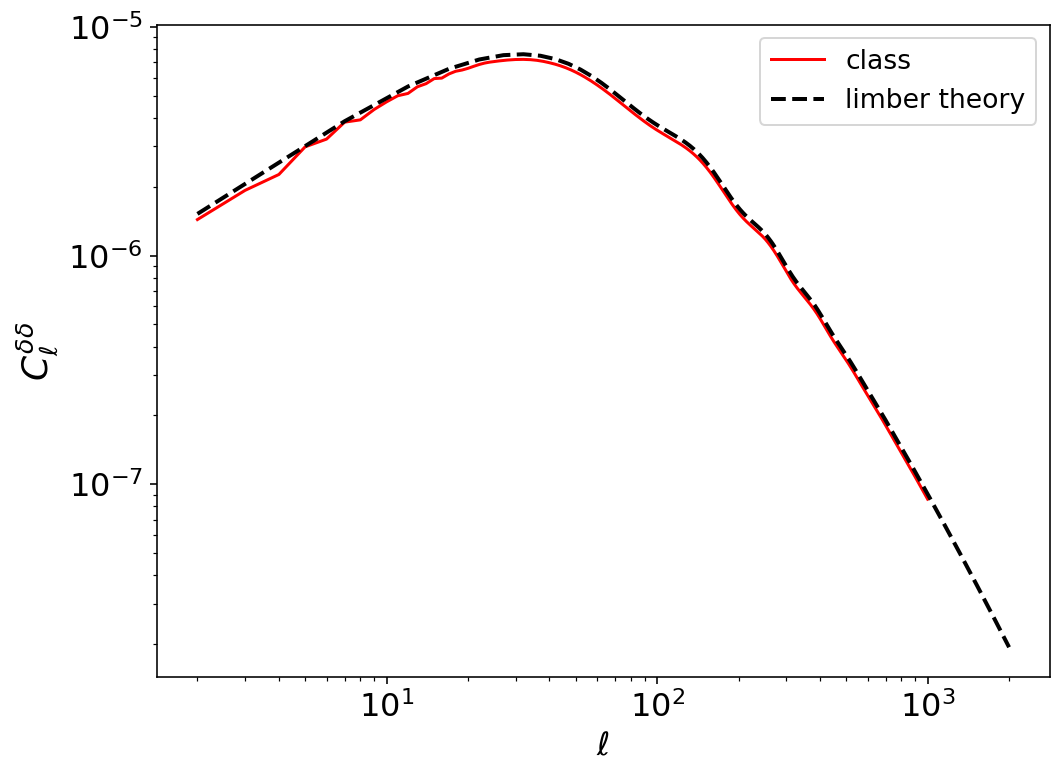

In [25]:
#plt.plot(l_camb,cl_dd, label='camb', linewidth=3)
plt.plot(ll[2:],cls_dd_class['dd'][0][2:], label='class', color='r')
plt.plot(l_limber,resarr_dd, label='limber theory',linestyle='dashed', color='k', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylabel(r'$C_{\ell}^{\delta\delta}$', fontsize=18)
plt.xlabel(r'$\ell$')

### $C_{\ell}^{\delta\kappa}$

Text(0.5, 0, '$\\ell$')

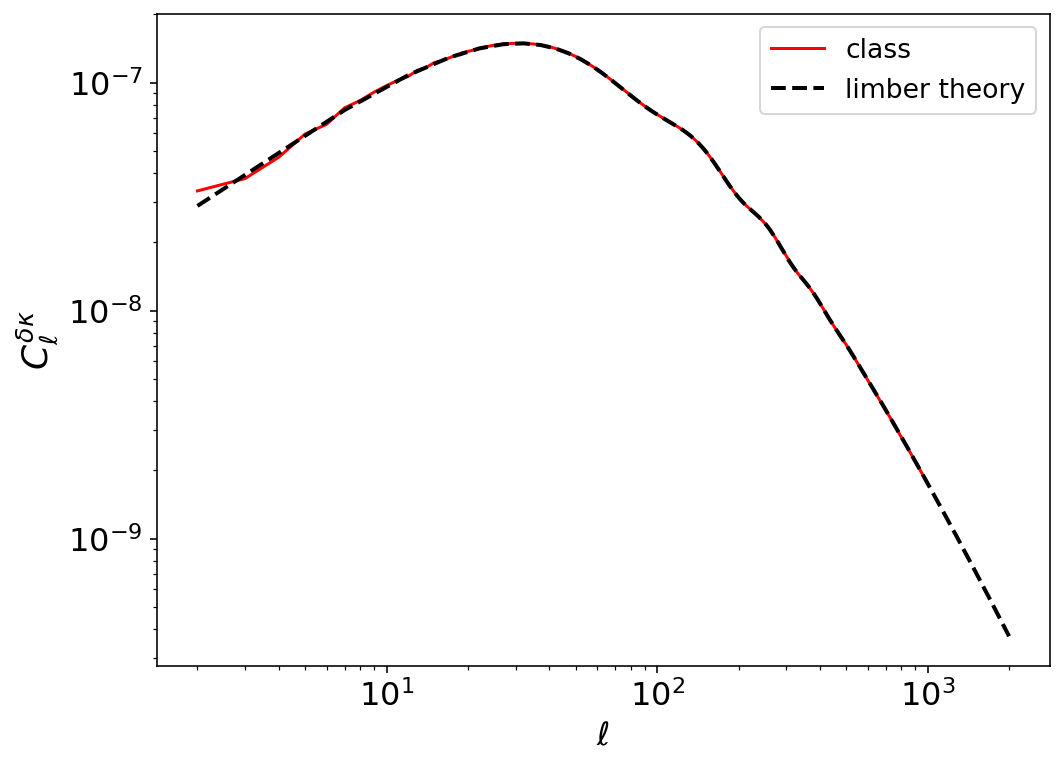

In [26]:

#plt.plot(l_camb,cl_dk, label='camb', linewidth=3)
plt.plot(ll[2:],(ll[2:]*(ll[2:]+1))*cls_dd_class['dl'][1][2:]/2, label='class', color='r')

plt.plot(l_limber,resarr_dk, label='limber theory',linestyle='dashed', color='k', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylabel(r'$C_{\ell}^{\delta\kappa}$', fontsize=18)
plt.xlabel(r'$\ell$')

## relative difference $\Delta C_{\ell}^{\delta\delta}/C_{\ell}^{\delta\delta}$

- theory & class
- camb & class

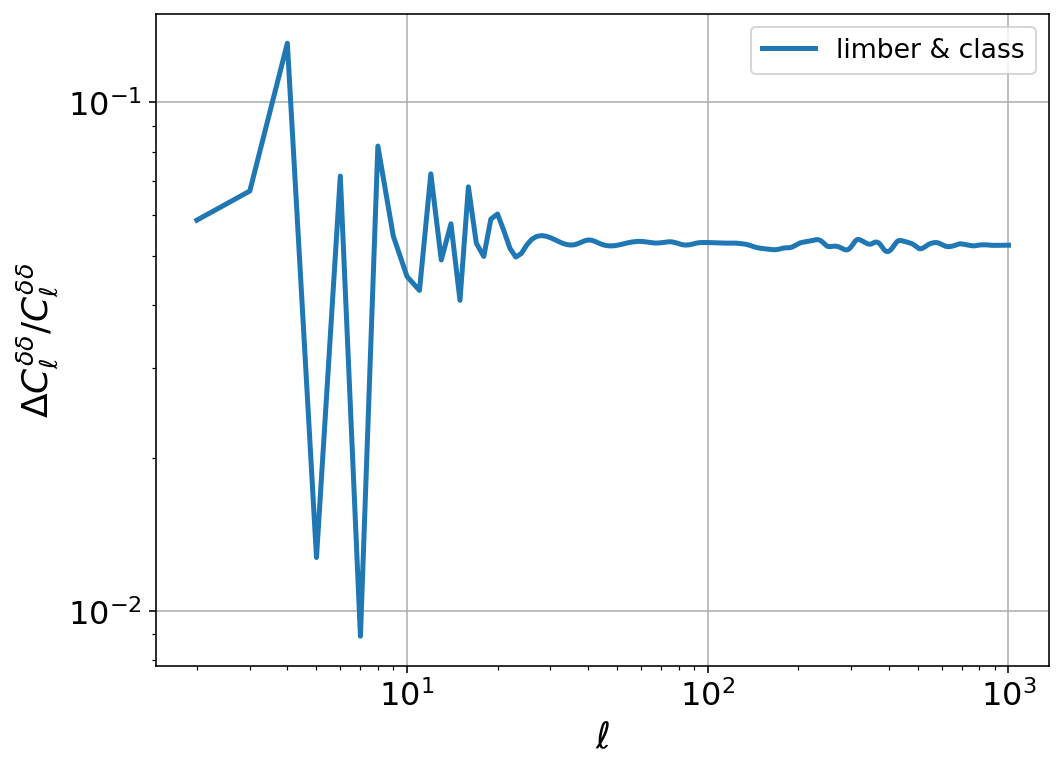

In [27]:
# set up interpolation function for camb result as Limber integration has different ell
#cl_dd_f = interp1d(l_camb,cl_dd,kind='cubic')

cl_dd_limber_f = interp1d(l_limber,resarr_dd,kind='cubic')


#plt.plot(ll[2:], np.abs((cls_dd_class['dd'][0][2:]-cl_dd_f(ll[2:]))/cls_dd_class['dd'][0][2:]), label = 'camb & class',linewidth=2.5)
plt.plot(ll[2:], np.abs((cls_dd_class['dd'][0][2:]-cl_dd_limber_f(ll[2:]))/cls_dd_class['dd'][0][2:]), label = 'limber & class',linewidth=2.5)


plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'$\Delta C_{\ell}^{\delta\delta}/C_{\ell}^{\delta\delta}$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()

## relative difference $\Delta C_{\ell}^{\delta\kappa}/C_{\ell}^{\delta\kappa}$

- theory & class
- camb & class

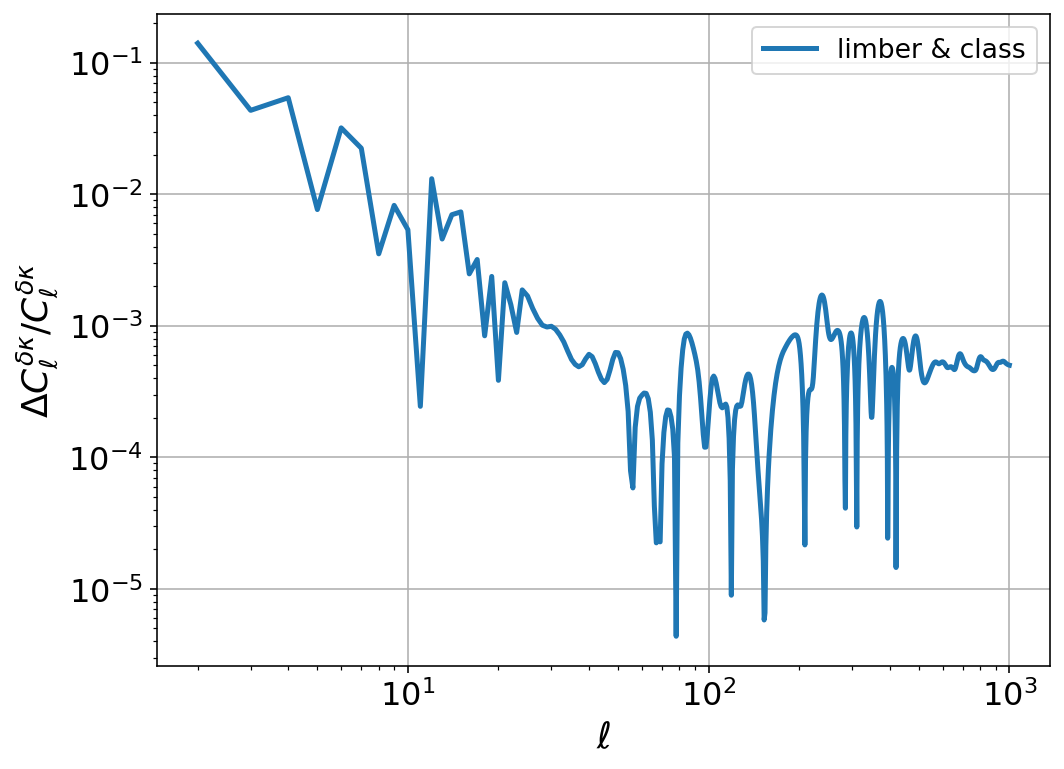

In [28]:


#cl_dk_f = interp1d(l_camb,cl_dk,kind='cubic')
cl_dk_class = (ll[2:]*(ll[2:]+1))*cls_dd_class['dl'][1][2:]/2
cl_dk_limber_f = interp1d(l_limber,resarr_dk,kind='cubic')


#plt.plot(ll[2:], np.abs((cl_dk_class-cl_dk_f(ll[2:]))/cl_dk_class), label = 'camb & class', linewidth=2.5)
plt.plot(ll[2:], np.abs((cl_dk_class-cl_dk_limber_f(ll[2:]))/cl_dk_class), label = 'limber & class',linewidth=2.5)


plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'$\Delta C_{\ell}^{\delta\kappa}/C_{\ell}^{\delta\kappa}$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()

## Ratio: $C_{\ell}^{\delta\kappa}/C_{\ell}^{\delta\delta}$

In [29]:
cl_dd_class  = cls_dd_class['dd'][0][2:]


# compute ratios and set ell-arrays
#ratio_camb   = cl_dk/cl_dd
ratio_limber = resarr_dk/resarr_dd
ratio_class = cl_dk_class / cl_dd_class


# interpolation
#ratio_camb_f = interp1d(l_camb,cl_dk/cl_dd,kind='cubic')
ratio_limber_f = interp1d(l_limber,resarr_dk/resarr_dd,kind='cubic')
ratio_class_f = interp1d(ll[2:],cl_dk_class / cl_dd_class,kind='cubic')

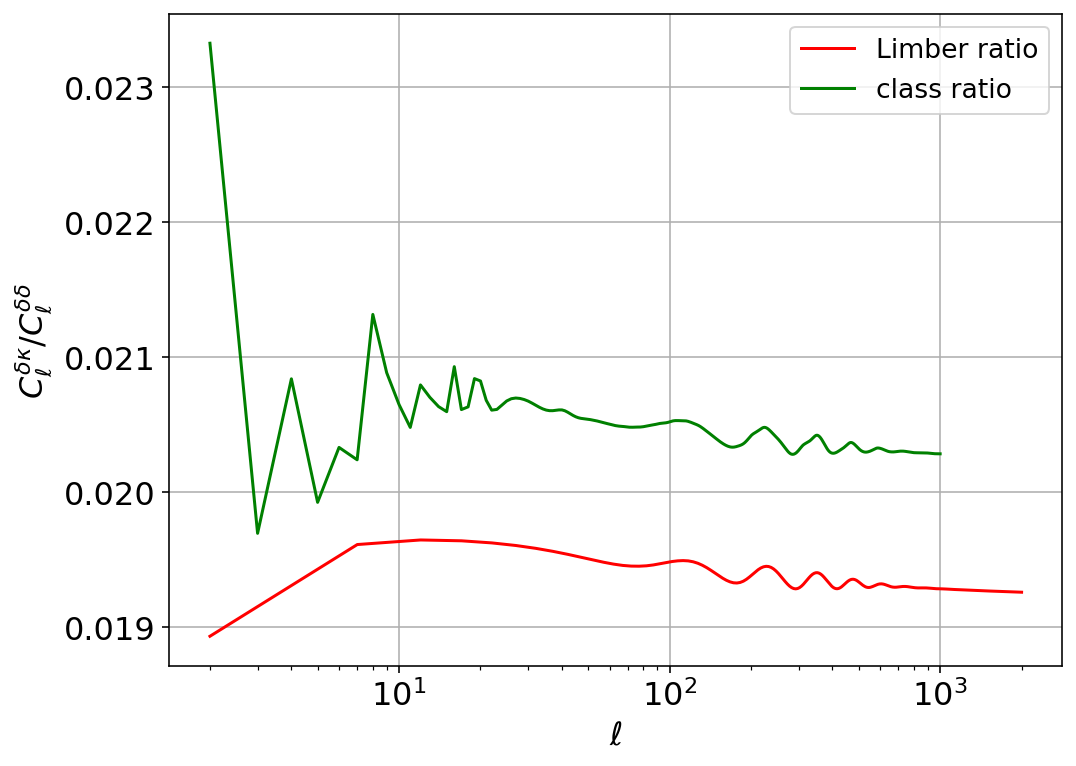

In [30]:
#plt.plot(l_camb,ratio_camb, color='b',label='camb ratio')
plt.plot(l_limber,ratio_limber,color='r',label='Limber ratio')

plt.plot(ll[2:],ratio_class,color='g',label='class ratio')
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell^{\delta\kappa}/C_\ell^{\delta\delta}$')
plt.legend()
plt.xscale('log')
plt.grid()

Text(0, 0.5, 'relative error in ratios')

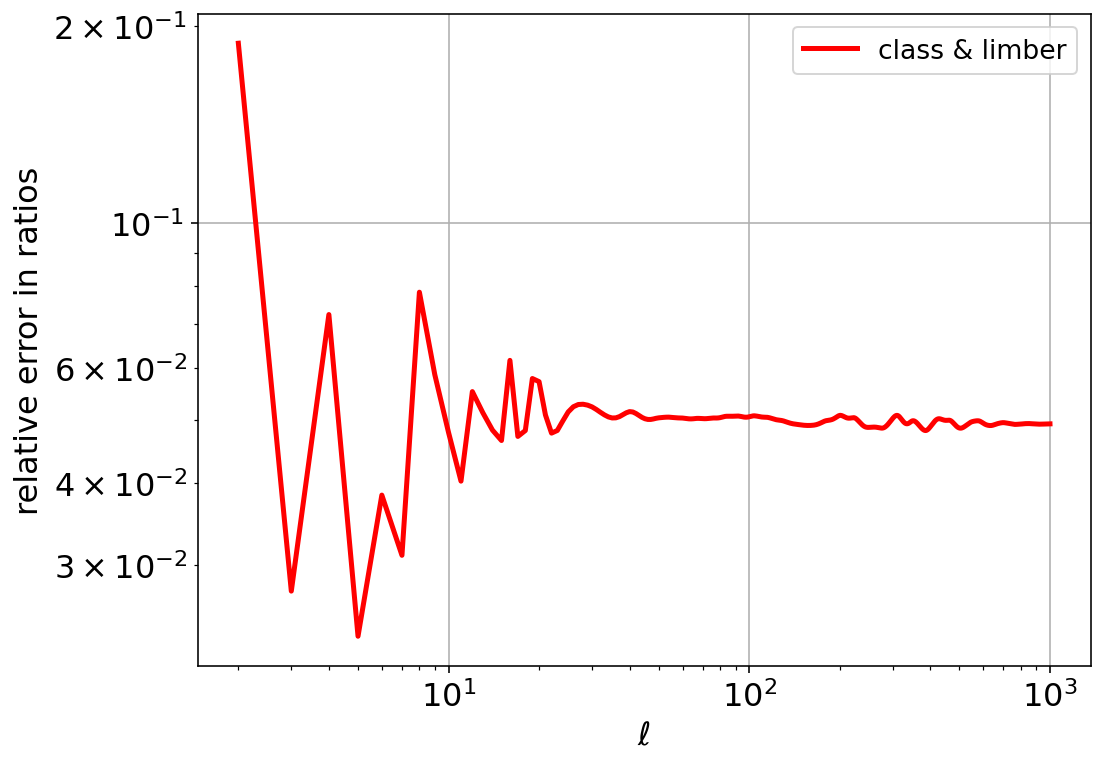

In [31]:
plt.plot(ll[2:], np.abs(ratio_class_f(ll[2:]) - ratio_limber_f(ll[2:]))/ratio_class_f(ll[2:]), label = 'class & limber', linewidth=2.5, color='r')
#plt.plot(ll[2:], np.abs(ratio_camb_f(ll[2:]) - ratio_limber_f(ll[2:]))/ratio_camb_f(ll[2:]), label = 'camb & limber',linewidth=2.5, color='g')

#plt.plot(ll[2:], np.abs(ratio_camb_f(ll[2:]) - ratio_class_f(ll[2:]))/ratio_class_f(ll[2:]), label = 'camb & class',linewidth=2.5, color='b')



plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel('relative error in ratios')

\begin{equation}
C_{\ell}^{\delta\kappa} = \frac{\ell(\ell +1)}{(\ell +1/2)^2}\frac{3 H_0^2\Omega_m(0)}{2}\int_{z_f^{\text{min}}}^{z_f^{\text{max}}}\text{d}z n_{\text{HI}}(z)\Sigma(z) (1+z)P_{\delta\delta}\Big[ \frac{\ell+1/2}{\chi(z)},z\Big]\int_{z_b^{\text{min}}}^{z_b^{\text{max}}} \text{d}z'n_{g}(z')\frac{\chi(z') - \chi(z)}{\chi(z)\chi(z')}
\end{equation}


## Ratio


\begin{equation}
\text{ratio} = \frac{\ell(\ell+1)}{(\ell +1/2)^2}\frac{3 H_0^2\Omega_m(0)}{2 H(z_f)}(1+z_f) \frac{\Delta z_f}{\Delta z_b} \chi(z_f) \int_{z_b^{\text{min}}}^{z_b^{\text{max}}} \frac{\chi(z) - \chi(z_f)}{\chi(z)}\text{d}z
\end{equation}

In [32]:
import scipy.integrate as integrate

def integrand(z, zf):
    return (comoving_dist_intp(z)-comoving_dist_intp(zf))/comoving_dist_intp(z)


#def ratio(zf,zb,deltazf, deltazb):
#    res = integrate.quad(lambda z: integrand(z, zf), zb-deltazb/2, zb+deltazb/2)[0]
#    
#    res = (3*Hubble_intp(0)**2*Omega_m0*(1+zf)/(2*Hubble_intp(zf)))*((deltazf/deltazb))*res*comoving_dist_intp(zf)
#    res = (ll*(ll+1))/((ll+1/2)**2)*res
#    
#    return res
Hub1 = Hubble_intp(mu_z1)

res =  1.5*(omch2+ombh2)*100.0**2/(cspeed*Hub1*cspeed)*(1.0+mu_z1)* (delta_z1/delta_z2)
res = res*comoving_dist_intp(mu_z1)
ratio = res * integrate.quad(lambda z: integrand(z, mu_z1), mu_z2-delta_z2/2, mu_z2+delta_z2/2)[0]


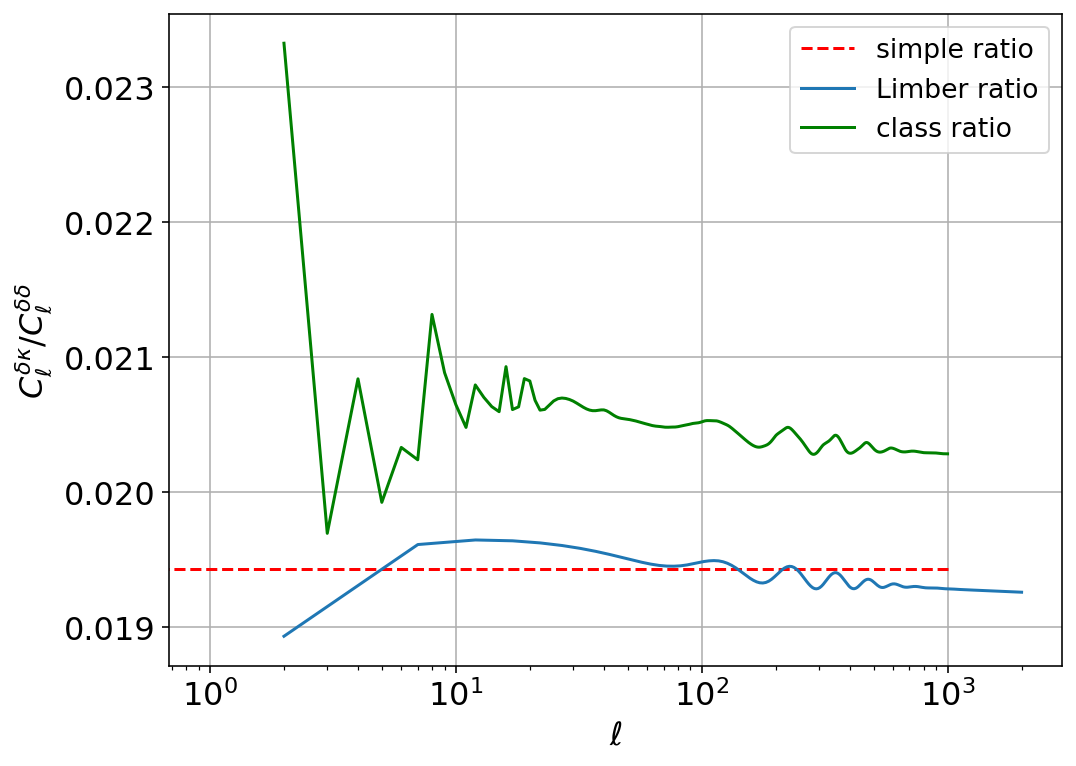

In [33]:


plt.plot(ll, ratio*np.ones(np.size(ll)) , label='simple ratio', color='r', linestyle='dashed')
plt.plot(l_limber,ratio_limber,label='Limber ratio')

plt.plot(ll[2:],ratio_class,color='g',label='class ratio')
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell^{\delta\kappa}/C_\ell^{\delta\delta}$')
plt.legend()
plt.xscale('log')
plt.grid()

In [34]:
ratio_simple_f = interp1d(ll,ratio*np.ones(np.size(ll)),kind='cubic')

Text(0, 0.5, 'relative error in ratios')

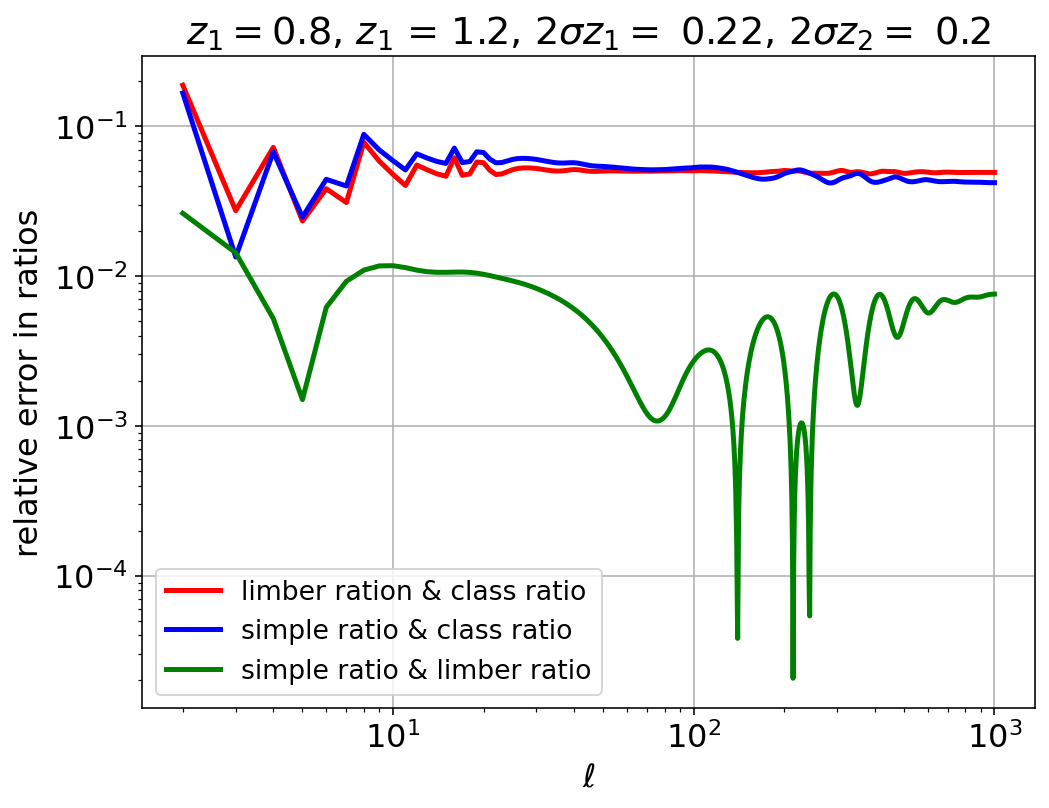

In [37]:
plt.plot(ll[2:], np.abs(ratio_class_f(ll[2:]) - ratio_limber_f(ll[2:]))/ratio_class_f(ll[2:]), label = 'limber ration & class ratio', linewidth=2.5, color='r')
plt.plot(ll[2:], np.abs(ratio_class_f(ll[2:]) - ratio_simple_f(ll[2:]))/ratio_class_f(ll[2:]), label = 'simple ratio & class ratio', linewidth=2.5, color='b')

plt.plot(ll[2:], np.abs(ratio_limber_f(ll[2:]) - ratio_simple_f(ll[2:]))/ratio_limber_f(ll[2:]), label = 'simple ratio & limber ratio', linewidth=2.5, color='g')



plt.title(r'$z_1 = $'+str(mu_z1)+', $z_1$ = '+str(mu_z2)+', $2\sigma z_1 = $ '+ str(2*sigma_z1)+', $2\sigma z_2 = $ '+ str(2*sigma_z2))

plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel('relative error in ratios')